# Assignment 3



## Car-Type Classiciation on a 'small' dataset:
 #### - Stanford Cars dataset: https://ai.stanford.edu/~jkrause/cars/car_dataset.html
 
 - 16.185 images
 - 196 classes
 - On average, 90 images per class

#%% md
### **Augmentations**

For your experiments, use at least one augmentation from each of the following types:
- Spatial Augmentations (rotation, mirroring, croppoing, ...)
- Use some other augmentations (color jitter, gaussian noise, ...).
- Use one (or more) of the following advanced augmentations:
   - **CutMix**: https://arxiv.org/pdf/1905.04899.pdf
   - **Mixup**: https://arxiv.org/pdf/1710.09412.pdf
#%% md
### **Experiments:** 
#### **Experiments 1:**
 Using your aforementioned augmentions:
 - Fine-tune ResNet, EfficientNet, and ConvNext for your augmented dataset for car type classification and compare them.
 - Compare the following on a model of your choice: Fine-Tuned model, model as fixed feature extractor, and model with a Combined Approach
 - Log your losses and accuracies into Tensorboard (or some other logging tool)
 - **Extra Point**: 
   - Fine-tune a Transformer-based model (e.g. SwinTransformer). Compare the performance (accuracy, confusion matrix, training time, loss landscape, ...) with the one from the convolutional models.
   
#### **Experiment 2:**
Try to get the best performance possible on this dataset
 - Fine-tune a pretrained neural network of your choice for classification.
 - Select a good training recipe: augmentations, optimizer, learning rate scheduling, classifier, loss function, ...

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import datasets, models
import yaml
import os
import pdb
import os
import scipy
import pandas as pd
import sys
import wandb
wandb.login()

# Add the path to utils
sys.path.append('..')
from template import utils


In [19]:
utils.set_random_seeds()

In [20]:
torch.use_deterministic_algorithms(False)

### Handling the data

In [21]:
# I am a big fan of config files and I believe it is a good practise
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])

config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4'}


In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.ImageFolder(
root='data/car_data/car_data/test',
transform=data_transforms['train']
)
val_dataset = datasets.ImageFolder(
root='data/car_data/car_data/train',
transform=data_transforms['val'])



Unfortunately the data is in a 50/50 train/eval split right now. We do not consider this optimal, however have not changed it yet due to time constraints.

In [23]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Create separate trainloader for the mixup training
trainloader_mixup = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

In [24]:
imgs, labels = next(iter(testloader))
print(f"Image Shapes: {imgs.shape}")
print(f"Label Shapes: {labels.shape}")

Image Shapes: torch.Size([64, 3, 224, 224])
Label Shapes: torch.Size([64])


### We can display some images from the dataset
Functions used will probably vastly differ from task to task

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


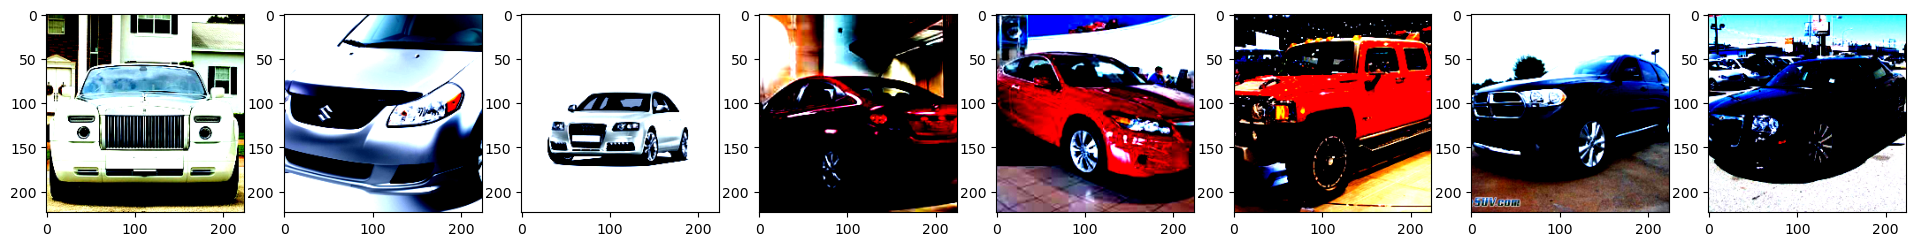

In [25]:
N_IMGS = 8
fig, ax = plt.subplots(1,N_IMGS)
fig.set_size_inches(3 * N_IMGS, 3)

ids = np.random.randint(low=0, high=len(train_dataset), size=N_IMGS)

for i, n in enumerate(ids):
    img = val_dataset[n][0].numpy().reshape(3,224, 224).transpose(1, 2, 0)
    ax[i].imshow(img)
    #ax[i].set_title(f"Img #{n}  Label: {train_dataset[n][1]}")
    #ax[i].axis("off")
plt.show()

### Creating the model

### Define main functions

The following functions are going to be reused throughout our assignment. We note, that the functions have been heavily insipred by Angel's code of session 3.

In [26]:
import torch.nn.functional as F

In [27]:
# Needed for cutmix or mixup
from torchvision.transforms import v2
mixup = v2.MixUp(num_classes=196)


In [28]:
def train_epoch(model, train_loader, optimizer, criterion, epoch, device, use_mixup = True):

    """ 
    Training a model for one epoch.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - epoch (int): Current epoch number.
    - device (torch.device): The device on which to perform training (e.g., 'cuda' or 'cpu').

    Returns:
    - float: Mean training loss for the epoch.
    - list: List of individual training losses for each batch.
    """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        if mixup:
            images, labels = mixup(images, labels)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, eval_loader, criterion, device):
    """ 
    Evaluating the model for either validation or test.

    Parameters:
    - model (nn.Module): The trained neural network model to be evaluated.
    - eval_loader (torch.utils.data.DataLoader): DataLoader for the validation or test dataset.
    - criterion (nn.Module): The loss function.
    - device (torch.device): The device on which to perform evaluation (e.g., 'cuda' or 'cpu').

    Returns:
    - float: Accuracy on the validation or test dataset.
    - float: Mean loss on the validation or test dataset.
    """    
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in eval_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs, scheduler=None, start_epoch=0):
    """ 
    Training a model for a given number of epochs.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler (optional).
    - start_epoch (int): Starting epoch number.

    Returns:
    - list: List of mean training losses for each epoch.
    - list: List of mean validation losses for each epoch.
    - list: List of individual training losses for each batch.
    - list: List of validation accuracies for each epoch.
    """
    wandb.watch(model, criterion, log='gradients', log_freq=100)

    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in tqdm(range(num_epochs)):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        if scheduler is not None:
            scheduler.step()
        train_loss.append(mean_loss)
        wandb.log({'epoch': epoch, 'loss': loss, 'accuracy': accuracy}, step=epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc


# ResNet18

In [29]:
from tqdm import tqdm

In [30]:
NUM_EPOCHS = int(config["NUM_EPOCHS"])
LR = float(config["LR"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
model = models.resnet18(pretrained=True)

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [33]:
# Adapt feedforward connection to our model
num_in_neurons = model.fc.in_features
model.fc = nn.Linear(num_in_neurons, 196)
model = model.to(device)

## Finetuning: ResNet

In [34]:
with wandb.init(project='finetune_resnet', config = config): 
    train_loss, val_loss, _ , valid_acc = train_model(model=model, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=15)
wandb.finish()

  7%|▋         | 1/15 [01:20<18:51, 80.82s/it]

Epoch 1/15
    Train loss: 5.12063
    Valid loss: 5.44704
    Accuracy: 0.6999017681728881%




 40%|████      | 6/15 [08:05<12:09, 81.10s/it]

Epoch 6/15
    Train loss: 3.61823
    Valid loss: 2.31965
    Accuracy: 54.494106090373286%




 73%|███████▎  | 11/15 [15:02<05:32, 83.07s/it]

Epoch 11/15
    Train loss: 2.9721
    Valid loss: 1.52043
    Accuracy: 70.12524557956779%




100%|██████████| 15/15 [20:38<00:00, 82.55s/it]

Epoch 15/15
    Train loss: 2.78189
    Valid loss: 1.31477
    Accuracy: 74.71758349705304%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▃▄▅▆▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▆▅▄▃▃▂▂▂▂▁▂▁▁▁
accuracy,74.71758
epoch,14
loss,1.31477


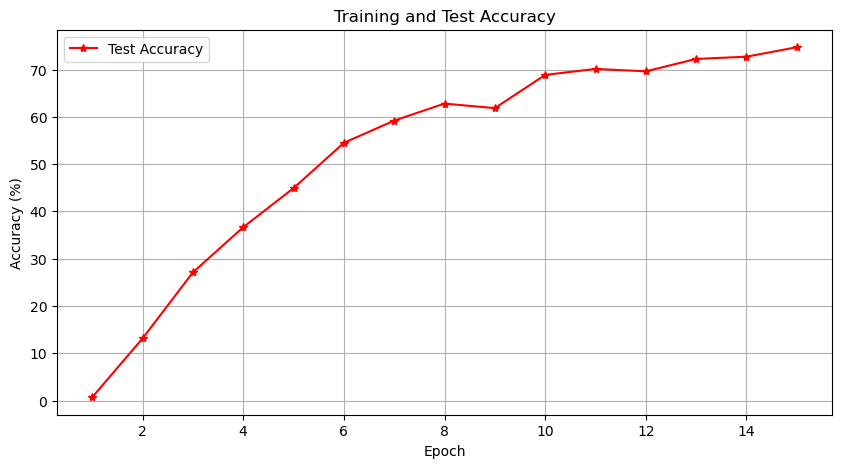

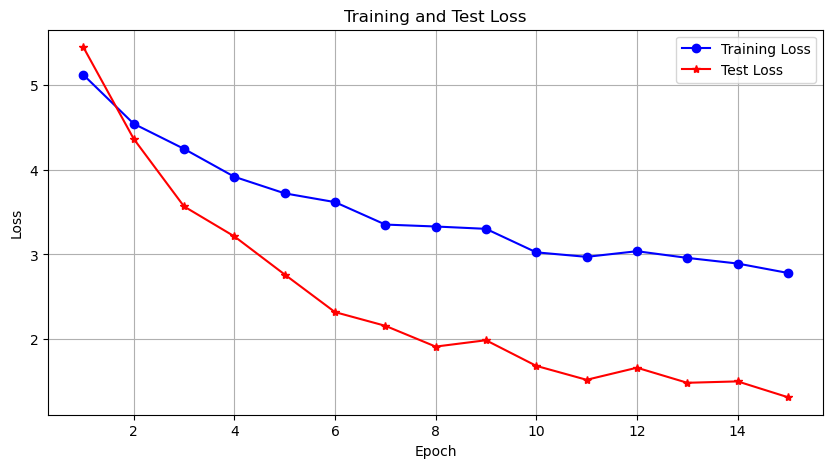

2.781892620381855

In [39]:
utils.plot_accuracy_epoch(valid_acc)
utils.plot_loss_epoch(train_loss, val_loss)

train_loss[-1]

## ConvNet as a Feature Extractor: ResNet

In [51]:
fixedModel = torchvision.models.resnet18(pretrained=True)

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Adapt feedforward connection to our model
num_in_neurons = model.fc.in_features
fixedModel.fc = nn.Linear(num_in_neurons, 196)

# Reinitialize the criterion and optimizer, in order to avoid optimizing the wrong parameters
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=LR)

fixedModel = fixedModel.to(device)

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [52]:
with wandb.init(project='feature_resnet', config = config): 
    train_loss, val_loss, _ , valid_acc = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=15)
wandb.finish()

  7%|▋         | 1/15 [01:22<19:16, 82.60s/it]

Epoch 1/15
    Train loss: 5.37621
    Valid loss: 5.47862
    Accuracy: 0.712180746561886%




 40%|████      | 6/15 [08:05<12:06, 80.69s/it]

Epoch 6/15
    Train loss: 4.8734
    Valid loss: 4.6305
    Accuracy: 9.037328094302556%




 73%|███████▎  | 11/15 [14:49<05:21, 80.49s/it]

Epoch 11/15
    Train loss: 4.65543
    Valid loss: 4.21202
    Accuracy: 15.95039292730845%




100%|██████████| 15/15 [20:09<00:00, 80.67s/it]

Epoch 15/15
    Train loss: 4.46155
    Valid loss: 3.9848
    Accuracy: 19.953339882121806%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▁▂▃▄▄▄▅▅▇▇▇▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▇▆▅▄▄▄▃▃▂▂▂▁▁▁
accuracy,19.95334
epoch,14
loss,3.9848


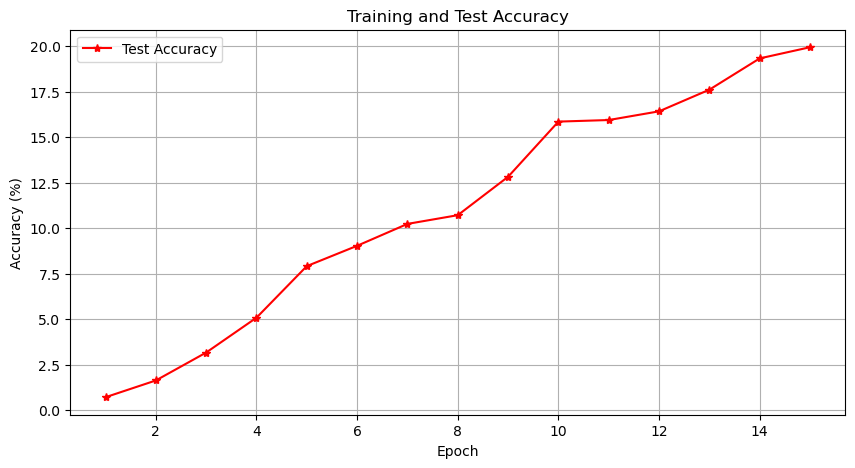

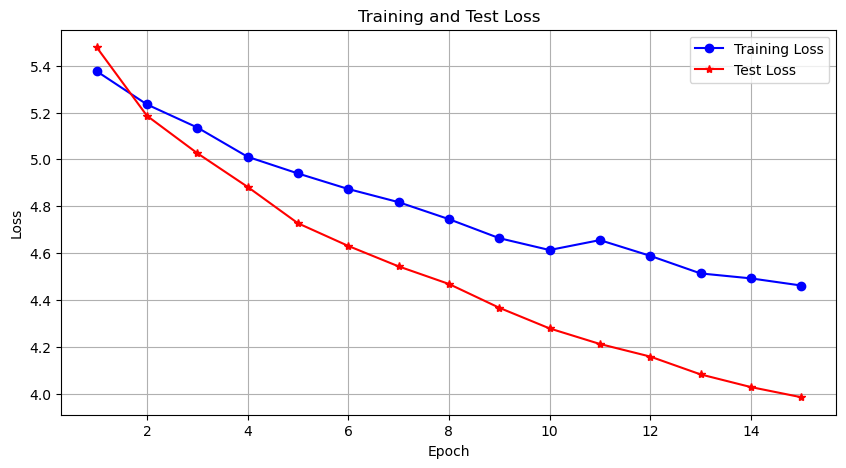

In [53]:
utils.plot_accuracy_epoch(valid_acc)
utils.plot_loss_epoch(train_loss, val_loss)

## Combined Approach: ResNet

First we train only the classifier for 10 epochs, then we fine tune the entire network

In [54]:
fixedModel = torchvision.models.resnet18(pretrained=True)

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Adapt feedforward connection to our model
num_in_neurons = model.fc.in_features
fixedModel.fc = nn.Linear(num_in_neurons, 196)

# Reinitialize the criterion and optimizer, in order to avoid optimizing the wrong parameters
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(fixedModel.parameters(), lr=LR)

fixedModel = fixedModel.to(device)

/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
with wandb.init(): 
    train_loss, val_loss, _ , valid_acc = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=10, start_epoch=0)

 10%|█         | 1/10 [01:20<12:02, 80.25s/it]

Epoch 1/10
    Train loss: 5.36061
    Valid loss: 5.46457
    Accuracy: 0.5157170923379175%




 60%|██████    | 6/10 [08:04<05:22, 80.74s/it]

Epoch 6/10
    Train loss: 4.86808
    Valid loss: 4.64769
    Accuracy: 8.68123772102161%




100%|██████████| 10/10 [13:25<00:00, 80.55s/it]

Epoch 10/10
    Train loss: 4.62723
    Valid loss: 4.27069
    Accuracy: 15.238212180746563%


Training completed


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▂▂▃▄▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▆▅▅▄▃▃▂▂▁
accuracy,15.23821
epoch,9
loss,4.27069


In [56]:
# Unfreezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = True

In [57]:
# Lowering learning rate
for g in optimizer.param_groups:
    g['lr'] *= 0.1

In [60]:
with wandb.init(project='combined_approach_resnet', config= config): 
    new_train_loss, new_val_loss, _ , new_valid_acc = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
    train_loader=trainloader, valid_loader=testloader, num_epochs=10, start_epoch=0)
wandb.finish()

  0%|          | 0/5 [00:04<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_2527724/1743112336.py", line 2, in <module>
    new_train_loss, new_val_loss, _ , new_valid_acc = train_model(model=fixedModel, optimizer=optimizer, criterion=criterion,
  File "/tmp/ipykernel_2527724/3414164237.py", line 118, in train_model
    accuracy, loss = eval_model(
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/tmp/ipykernel_2527724/3414164237.py", line 65, in eval_model
    for images, labels in eval_loader:
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/home/user/lschulze/anaconda3/envs/lab2/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1328, in _next_data
    idx, data = self._get_data()
  File "/home/user/lsc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


KeyboardInterrupt: 

In [59]:
cat_train_loss = train_loss + new_train_loss
cat_val_loss = val_loss + new_val_loss
cat_valid_acc = val_acc + new_valid_acc

NameError: name 'new_train_loss' is not defined

# EfficientNet

In [62]:
model = torchvision.models.EfficientNet(weights=True)

model

TypeError: EfficientNet.__init__() got an unexpected keyword argument 'weights'

In [ ]:
model = torchvision.models.EfficientNet(pretrained=True)

# Freezing model parameters
for param in fixedModel.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Adapt feedforward connection to our model
num_in_neurons = model.fc.in_features
model.fc = nn.Linear(num_in_neurons, 196)

# Reinitialize the criterion and optimizer, in order to avoid optimizing the wrong parameters
criterion = nn.CrossEntropyLoss()  # Note, that this already includes a Softmax!
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

model = model.to(device)